In [ ]:
import argparse
import os
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from keras.layers import (Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, LSTM, Reshape, TimeDistributed,  GlobalAveragePooling1D, BatchNormalization)
#from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers.merge import Average
from keras.models import Model

from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import cv2
from easydict import EasyDict
%matplotlib inline

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        print("test ",filename)
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        return np.array(framearray)

    def get_UCF_classname(self, filename):
        return filename[filename.find('_') + 1:filename.find('_', 2)]

In [ ]:
def save_history(history, result_dir):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    nb_epoch = len(acc)

    with open(os.path.join(result_dir, '2DCNN+LSTM_Result.txt'), 'w') as fp:
        fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
        for i in range(nb_epoch):
            fp.write('{}\t{}\t{}\t{}\t{}\n'.format(
                i, loss[i], acc[i], val_loss[i], val_acc[i]))

In [ ]:
def loaddata(video_dir, vid3d, nclass, result_dir, color=False, skip=True):
    folders = os.listdir(video_dir)
    X = []
    labels = []
    labellist = []

    for folder in folders:
      files = os.listdir(video_dir+"/"+folder)
      pbar = tqdm(total=len(files))
      for filename in files:
          pbar.update(1)
          if filename == '.DS_Store':
              continue
          name = os.path.join(video_dir+"/"+folder, filename)
          # label = vid3d.get_UCF_classname(folder)
          label = folder
          if label not in labellist:
              if len(labellist) >= nclass:
                  continue
              labellist.append(label)
          labels.append(label)
          X.append(vid3d.video3d(name, color=color, skip=skip))

      pbar.close()
    with open(os.path.join(result_dir, '2DCNN+LSTM_Classes.txt'), 'w') as fp:
        for i in range(len(labellist)):
            fp.write('{}\n'.format(labellist[i]))

    for num, label in enumerate(labellist):
        for i in range(len(labels)):
            if label == labels[i]:
                labels[i] = num
    if color:
        return np.array(X).transpose((0, 2, 3, 4, 1)), labels
    else:
        return np.array(X).transpose((0, 2, 3, 1)), labels


In [ ]:
args = EasyDict({
    "batch": 32,
    "epoch":20,
    "videos":'/content/drive/My Drive/videos/Input',
    "nclass":23,
    "color":True,
    "skip":False,
    "depth":12,
    "output": '/content/drive/My Drive/FinalResult3DCNN/2DCNN+LSTM_Output'
})

In [ ]:
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
fname_npz = args.output+'/dataset_{}_{}_{}.npz'.format(
    args.nclass, args.depth, args.skip)


vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = args.nclass
if os.path.exists(fname_npz):
    loadeddata = np.load(fname_npz)
    X, Y = loadeddata["X"], loadeddata["Y"]
else:
    x, y = loaddata(args.videos, vid3d, args.nclass,
                    args.output, args.color, args.skip)
    X = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
    Y = np_utils.to_categorical(y, nb_classes)

    X = X.astype('float32')
    np.savez(fname_npz, X=X, Y=Y)
    print('Saved dataset to dataset.npz.')
print('X_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))

X_shape:(3230, 32, 32, 12, 3)
Y_shape:(3230, 23)


input shape [(None, 32, 32, 12, 3), (None, 32, 32, 12, 3)]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_distributed_19_input (Inpu (None, 32, 32, 12, 3 0                                            
__________________________________________________________________________________________________
time_distributed_28_input (Inpu (None, 32, 32, 12, 3 0                                            
__________________________________________________________________________________________________
time_distributed_19 (TimeDistri (None, 32, 32, 12, 3 896         time_distributed_19_input[0][0]  
__________________________________________________________________________________________________
time_distributed_28 (TimeDistri (None, 32, 32, 12, 3 896         time_distributed_28_input[0][0]  
_________________________________

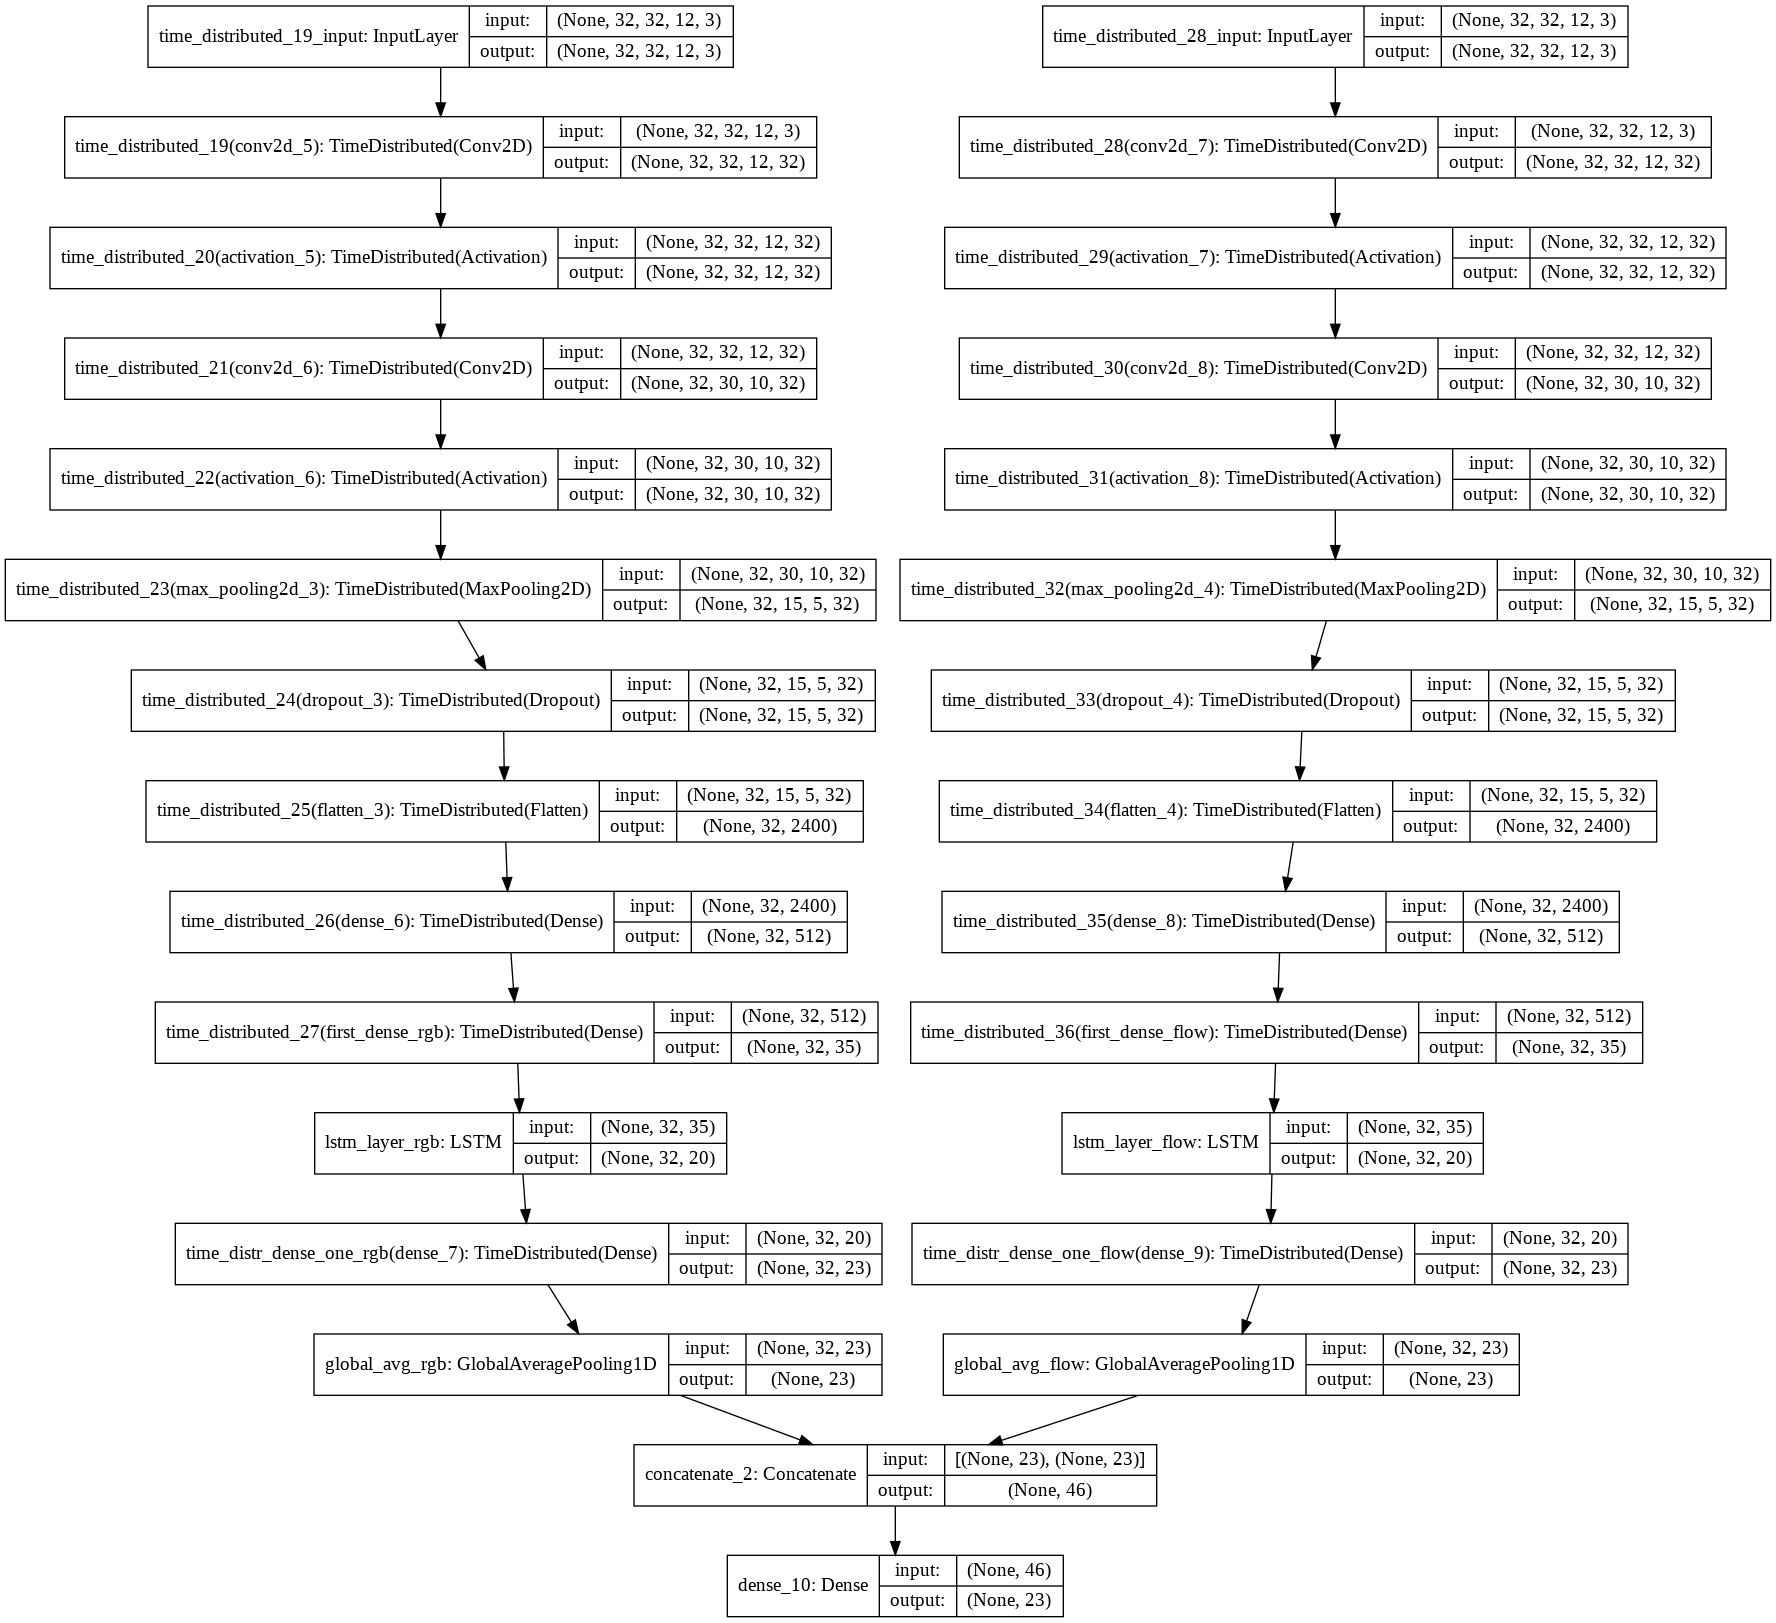

In [ ]:
# Define model
def build_rgb_model():
    model=Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same'), input_shape=(X.shape[1:])))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(Conv2D(32, (3, 3))))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(512)))

    model.add(TimeDistributed(Dense(35, name="first_dense_rgb" )))

    model.add(LSTM(20, return_sequences=True, name="lstm_layer_rgb"));

    model.add(TimeDistributed(Dense(nb_classes), name="time_distr_dense_one_rgb"))
    model.add(GlobalAveragePooling1D(name="global_avg_rgb"))

    return model


def build_flow_model():
    model=Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same'), input_shape=(X.shape[1:])))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(Conv2D(32, (3, 3))))
    model.add(TimeDistributed(Activation('relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(512)))

    model.add(TimeDistributed(Dense(35, name="first_dense_flow" )))

    model.add(LSTM(20, return_sequences=True, name="lstm_layer_flow"));

    model.add(TimeDistributed(Dense(nb_classes), name="time_distr_dense_one_flow"))
    model.add(GlobalAveragePooling1D(name="global_avg_flow"))

    return model

rgb_model = build_rgb_model()
flow_model = build_flow_model()

#model = Sequential()
#model.add(Concatenate([rgb_model, flow_model]))
#model.add(Average([rgb_model, flow_model]))
modeltmp = concatenate([rgb_model.output, flow_model.output], axis=-1)
# Merge
#merged = concatenate([rgb_model, flow_model])

# Dense
#dense_out = Dense(nb_classes, activation='softmax')(merged)

# build and compile model
#model = Model(inputs=[X, X], outputs=[dense_out])
modeltmp = Dense(nb_classes, activation='sigmoid')(modeltmp)
model = Model(inputs=[rgb_model.input, flow_model.input], outputs=modeltmp)
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(), metrics=['accuracy'])
#model.build(X.shape[1:])
print("input shape",model.input_shape)
model.summary()
plot_model(model, show_shapes=True,
            to_file=os.path.join(args.output, 'model.png'))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=43)
history = model.fit([X_train,X_train], Y_train, validation_data=([X_test,X_test], Y_test), batch_size=args.batch,epochs=args.epoch, verbose=1, shuffle=True)

Train on 2584 samples, validate on 646 samples
Epoch 1/20
2584/2584 [==============================] - 164s 63ms/step - loss: 2.0675 - accuracy: 0.2941 - val_loss: 1.4109 - val_accuracy: 0.3019
Epoch 2/20
2584/2584 [==============================] - 161s 62ms/step - loss: 1.4385 - accuracy: 0.2961 - val_loss: 1.3717 - val_accuracy: 0.3019
Epoch 3/20
2584/2584 [==============================] - 160s 62ms/step - loss: 1.4265 - accuracy: 0.2961 - val_loss: 1.3900 - val_accuracy: 0.3019
Epoch 4/20
2584/2584 [==============================] - 163s 63ms/step - loss: 1.4238 - accuracy: 0.2961 - val_loss: 1.3825 - val_accuracy: 0.3019
Epoch 5/20
2584/2584 [==============================] - 160s 62ms/step - loss: 1.4271 - accuracy: 0.2984 - val_loss: 1.3763 - val_accuracy: 0.3065
Epoch 6/20
2584/2584 [==============================] - 157s 61ms/step - loss: 1.4230 - accuracy: 0.3038 - val_loss: 1.3567 - val_accuracy: 0.3189
Epoch 7/20
2584/2584 [==============================] - 159s 62ms/step 

In [ ]:
model.evaluate([X_test,X_test], Y_test, verbose=0)

In [ ]:
model_json = model.to_json()
if not os.path.isdir(args.output):
    os.makedirs(args.output)
with open(os.path.join(args.output, '2DCNN+LSTM_Model.json'), 'w') as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(args.output, '2DCNN+LSTM_Model.hd5'))

loss, acc = model.evaluate([X_test,X_test], Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 1.3663098420890123
Test accuracy: 0.301857590675354


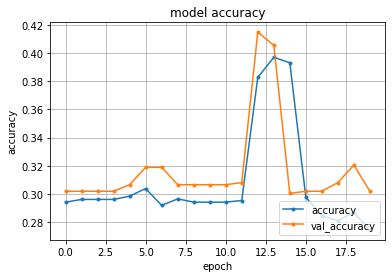

In [ ]:
save_history(history, args.output)
plt.plot(history.history['accuracy'], marker='.')
plt.plot(history.history['val_accuracy'], marker='.')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.savefig(os.path.join(args.output, '2DCNN+LSTM_Model_Accuracy.png'))
plt.show()

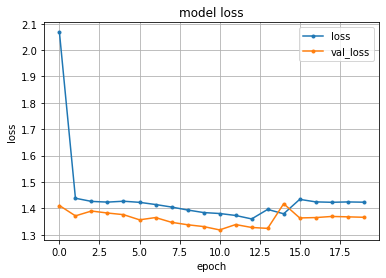

In [ ]:
plt.plot(history.history['loss'], marker='.')
plt.plot(history.history['val_loss'], marker='.')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig(os.path.join(args.output, '2DCNN+LSTM_Model_Loss.png'))
plt.show()

In [ ]:
# Prepare data for prediction
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
vid3d = Videoto3D(img_rows, img_cols, frames)
test_data = vid3d.video3d('/content/drive/My Drive/videos/Input/Fighting/Fighting014_x264_15.mp4', color=args.color, skip=args.skip)
t = np.expand_dims(test_data, axis=0)
print(t.shape)
td = np.array(t).transpose((0, 2, 3, 1, 4))
print(td.shape)
ls = [test_data]

test  /content/drive/My Drive/videos/Input/Fighting/Fighting014_x264_15.mp4
(1, 12, 32, 32, 3)
(1, 32, 32, 12, 3)


In [ ]:
from keras.models import load_model
from keras.models import model_from_json
import json
with open(os.path.join(args.output, '2DCNN+LSTM_Model.json'),'r') as f:
    print(type(f))
    for i in f:
      print(type(i))
      model_json = i
      break

model = model_from_json(model_json)
model.load_weights(os.path.join(args.output, '2DCNN+LSTM_Model.hd5'))

<class '_io.TextIOWrapper'>
<class 'str'>


In [ ]:
predictions = model.predict(td)
print(predictions)

ValueError: ignored

In [ ]:

# Process predicted result
class_names = ['Fighting','Stealing','walking','digging','RoadAccidents','Shooting']
class_names[np.argmax(predictions)]


NameError: ignored